In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as la
import polars as pl
import pandas as pd
import datetime as dt
import os
from pathlib import Path
from dask.distributed import Client, LocalCluster, as_completed
from dask import delayed
from runpy import run_path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import networkx as nx
import raphtory as rp
import umap.umap_ as umap
import streamlit as st
from sklearn.preprocessing import StandardScaler

#import local2global as l2g # ADDED

import torch
import torch_geometric as tg
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import LargestConnectedComponents
from torch_geometric.utils import to_networkx, from_networkx, one_hot
from torch_geometric.nn import Node2Vec, GCNConv, VGAE
import torch.nn.functional as F

In [6]:
from l2gv2.datasets import DataLoader
from l2gv2.patch.patch import Patch

In [20]:
PATH = 'l2gv2/datasets/data/nas/'

# <font color="grey">New Autonomous Systems dataset </font>

The purpose of this notebook is to walk through the graph embedding and alignment process in a self-contained way. The full existing Local2Global package is available [here](https://github.com/LJeub/Local2Global_embedding) and the expectation is to pick parts from it as a starting point. It is also available in on this repository in the Local2Global_embedding folder for reference.

### <font color="grey">  Table of Contents</font>

1. #### <a href='#chapter1'>Data</a>
2. #### <a href='#chapter2'>Embedding</a>
3. #### <a href='#chapter3'>Visualisation</a>

###  <a id='chapter1'> <font color="grey">1. Data </font></a>

The data can be accessed via the dataloader. It is saved in the datasets/data/nas directory in two parquet files. There are many alternative ways of doing this. One option to explore is to have the datasets available as in [torch_geometric datasets](https://pytorch-geometric.readthedocs.io/en/2.6.0/modules/datasets.html).

In [7]:
dl = DataLoader(dset='nas')

The data is stored in one dataframe for the nodes (including all the features) and one for the edges (including edge weights).

In [8]:
# Get the nodes
node_df = dl.get_nodes()
node_df.head()

timestamp,nodes,nodetype,country,asname
datetime[μs],str,str,str,str
2024-09-14 00:00:00,"""AS7029""","""asn""","""US""","""WINDSTREAM"""
2024-09-14 00:00:00,"""AS32984""","""asn""","""US""","""RUELALA-INC"""
2024-09-14 00:00:00,"""AS136106""","""asn""","""ID""","""FIBERSTAR-AS-I"""
2024-09-14 00:00:00,"""AS58495""","""asn""","""ID""","""HSPNET-AS-I"""
2024-09-14 00:00:00,"""AS3491""","""asn""","""US""","""BTN-ASN"""


In [9]:
edge_df = dl.get_edges()
edge_df.head()

timestamp,source,dest,weight
datetime[μs],str,str,i64
2024-09-14 00:00:00,"""AS7029""","""AS32984""",1
2024-09-14 00:00:00,"""AS7029""","""AS19692""",1
2024-09-14 00:00:00,"""AS7029""","""AS55037""",1
2024-09-14 00:00:00,"""AS7029""","""AS1820""",1
2024-09-14 00:00:00,"""AS7029""","""AS16265""",1


Ultimately, working with the people at Pometry, we want to use the [Raphtory](https://www.raphtory.com/) graph format.

In [10]:
# Raphtory format
g = dl.get_graph()

The Raphtory formal is still work in progress but one can contribute to their code (based in Rust), contribute to the discussion on their Slack (linked on their page) or directly get in touch with [Lucas Jeub](https://github.com/LJeub) and/or Ben Steer.

In [11]:
print("Stats on the graph structure:")

number_of_nodes = g.count_nodes()
number_of_edges = g.count_edges()
total_interactions = g.count_temporal_edges()

print("Number of nodes (AS nodes):", number_of_nodes)
print("Number of unique edges (src,dst):", number_of_edges)
print("Total interactions (edge updates):", total_interactions)

print("Stats on the graphs time range:")

earliest_datetime = g.earliest_date_time
latest_datetime = g.latest_date_time

print("Earliest datetime:", earliest_datetime)
print("Latest datetime:", latest_datetime)

Stats on the graph structure:
Number of nodes (AS nodes): 85428
Number of unique edges (src,dst): 914346
Total interactions (edge updates): 16717484
Stats on the graphs time range:
Earliest datetime: 2024-09-14 00:00:00+00:00
Latest datetime: 2024-10-13 00:00:00+00:00


In [12]:
print("The node features are: ", g.nodes.properties.keys())

The node features are:  ['asname', 'country', 'nodetype']


The graphs we are dealing are **temporal**, meaning that nodes and edges have timestamps. One can interpret this as having one graph for each point in time, with a possible overlap of nodes and edges.

In [13]:
dates = dl.get_dates()

For this particular dataset, the graph for each day represents a patch. In order to apply graph neural networks to each patch, we need to process these into the Data format used by pytorch-geometric, described [here](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html). In particular, for each patch we need to enumerate the nodes and use these indices to designate the nodes. We need a dictionary that maps the nodes in each patch to their names and we need to encode the node and edge features.

In [54]:
all_node_names = dl.get_node_list()
nodes_index = {x : i for i, x in enumerate(all_node_names)}
all_nodes = list(nodes_index.values())

In [57]:
# Encode nodes present at each date
nodes = {}
node_dict = {}
for d in dates:
    temp_nodes = dl.get_node_list(ts=d)
    nodes[d] = [nodes_index[x] for x in temp_nodes]
    node_dict[d] = {x : i for i, x in enumerate(nodes[d])}

In [17]:
list_nodes_renumbered=[]
for l in all_nodes:
    list_nodes_renumbered.append( [nodex_index[i] for i in l])

In [21]:
# Encode country codes
cc = pl.read_csv(PATH+'country_codes.csv')
countrycode_dict = dict(zip(cc["alpha-2"].to_list(), range(cc.shape[0])))
#cc_one_hot = one_hot(torch.tensor(list(countrycode_dict.values()), dtype=torch.int64))

In [22]:
# Assign country code index to each node. The way this is done is a bit convoluted, as some nodes are assigned to both a country and to 'ZZ'
# in the database, so we need to fix that. This should be done in pre-processing
df = dl.get_nodes().with_columns(
    pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64).alias('cc')
).select(["nodes", "cc"]).group_by("nodes").agg(pl.col("cc").min().cast(pl.Int64).alias("cc")).sort(["cc","nodes"])
node_cc_dict = dict(zip(df["nodes"].to_list(), df["cc"].to_list()))

In [23]:
# For every day, create a list of node features
features = {}
for d in dates:
    features[d] = one_hot(torch.tensor(dl.get_nodes(ts=d).select(
        pl.col("country").replace(old=pl.Series(countrycode_dict.keys()), new=pl.Series(countrycode_dict.values())).cast(pl.Int64)
    ).to_numpy().flatten()))

In [24]:
features[dates[3]].shape

torch.Size([84575, 250])

In [25]:
# Create pytorch-geometric Data object
tg_graphs = {}
for d in tqdm(dates):
    edges = dl.edges.filter(pl.col('timestamp')==d).select(
        pl.col('source').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64),
        pl.col('dest').replace(old=pl.Series(node_dict[d].keys()), new=pl.Series(node_dict[d].values())).cast(pl.Int64)
    ).to_numpy()
    edge_index = torch.tensor([tuple(x) for x in edges], dtype=torch.long).t().contiguous()
    tgraph = Data(edge_index=edge_index)
    # Add features - problem is that for the embedding we only want those present at a given time
    tgraph.x = features[d]
    tg_graphs[d] = tgraph

  0%|          | 0/30 [00:00<?, ?it/s]

In [26]:
for i, d in enumerate(dates):
    tg_graphs[d].nodes=torch.tensor(list_nodes_renumbered[i])

In [27]:
# Select one date to test embedding
data = tg_graphs[dates[0]]

###  <a id='chapter2'> <font color="grey">2. Embedding </font></a>

For the embedding, we use the architecture of a Variational Graph Autoencoder. Given a graph $G=(V,E)$ with $|V|=n$ nodes and node features $\vct{x}_i\in \R^d$, $i\in [n]$, denote by $\vct{X}=[\vct{x}_1,\dots,\vct{x}_n]^T\in \R^{n\times d}$ the features matrix and by $A=(a_{ij})\in \{0,1\}^{n\times n}$ the adjacency matrix of the graph. The **encoder** produces latent representations $\vct{z}_i\in \R^k$ for $i\in [n]$, which are sampled from the inference model
\begin{equation*}
  q(\vct{z}_i \ | \ \vct{X},\vct{A}) = \mathcal{N}(\vct{z}_i \ | \ \vct{\mu}_i,\mathrm{diag}(\vct{\sigma}_i)).
\end{equation*}
The means $\mu_i$ and variances $\mathrm{diag}(\vct{\sigma}_i)$ are parametrized using an encoder network, for example, a graph convolutional neural network (GCN). Denoting by $\vct{Z}=[\vct{z}_1,\dots,\vct{z}_n]^T$ the matrix of latent represenations and by $\vct{\mu}$ and $\vct{\sigma}$ the matrices representing the means and variances, we have
\begin{equation*}
  \vct{\mu} = \mathrm{GCN}_{\mu}(\vct{X},\vct{A}), \quad \quad \log \vct{\sigma} = \mathrm{GCN}_{\sigma}(\vct{X},\vct{A}).
\end{equation*}
The **generative model** is a distribution on the adjacency matrix,
\begin{equation*}
  p(\mtx{A}\ | \ \vct{Z}) = \prod_{i,j} p(a_{ij} \ | \ \vct{z}_i,\vct{z}_j).
\end{equation*}
It is convenient to use
\begin{equation*}
  p(a_{ij}=1 \ | \ \vct{z}_i,\vct{z}_j) = \sigma(\vct{z}_i^T\vct{z}_j),
\end{equation*}

where $\sigma$ is the logistic sigmoid. In order to train the model, we optimize the evidence lower bound
\begin{equation*}
  \mathcal{L} = \Expect_{q(\vct{Z}\ | \ \vct{X},\vct{A})}[\log p(\mtx{A}\ | \ \mtx{Z})]-\mathrm{D}_{\mathrm{KL}}(q(\mtx{Z}\ | \ \mtx{X},\mtx{A}) \ \| \ p(\mtx{Z})).
\end{equation*}

In [28]:
class Encoder(torch.nn.Module):
    """
    Implement a Graph Convolutional Network (GCN) as encoder
    """
    def __init__(self, dim, num_node_features, hidden_dim=128, cached=True, bias=True, add_self_loops=True, normalize=True):
        super().__init__()
        self.x_conv = tg.nn.GCNConv(num_node_features, 
                                    hidden_dim, 
                                    cached=cached, 
                                    bias=bias, 
                                    add_self_loops=add_self_loops,
                                    normalize=normalize)
        self.mean_conv = tg.nn.GCNConv(hidden_dim, 
                                       dim, 
                                       cached=cached,
                                       bias=bias, 
                                       add_self_loops=add_self_loops,
                                       normalize=normalize)
        self.var_conv = tg.nn.GCNConv(hidden_dim, 
                                      dim, 
                                      cached=cached, 
                                      bias=bias, add_self_loops=add_self_loops,
                                      normalize=normalize)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index

        x = self.x_conv(x, edge_index)
        x = F.relu(x)

        mu = self.mean_conv(x, edge_index)
        sigma = self.var_conv(x, edge_index)
        return mu, sigma

In [29]:
model = VGAE(encoder=Encoder(64, data.num_node_features))
#model = VGAE(encoder=VGAEconv(2, test_data.num_node_features))

In [30]:
def VGAE_loss(model, data):
    return model.recon_loss(model.encode(data), data.edge_index) + model.kl_loss() / data.num_nodes

In [31]:
def train(data, model, loss_fun, num_epochs=100, verbose=True, lr=0.01, logger=lambda loss: None):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    # schedule = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
    for e in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        loss = loss_fun(model, data)
        loss.backward()
        optimizer.step()
        losses.append(float(loss))
        if verbose:
            if not e % 20:
                print(f'epoch {e}: loss={loss.item()}')
        # schedule.step()
    return model, losses

In [32]:
model, losses = train(data, model, VGAE_loss, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0: loss=6.706134796142578
epoch 20: loss=0.9890369176864624
epoch 40: loss=0.9149158596992493
epoch 60: loss=0.8871313333511353
epoch 80: loss=0.8734854459762573


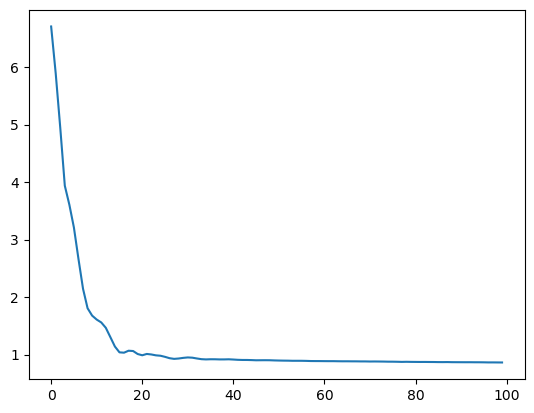

In [33]:
plt.plot(losses)
plt.show()

In [34]:
embedding = model.encode(data).detach().numpy()
embedding.shape

(84592, 64)

In the original L2G code, there is a Patch class handling patches.

###  <a id='chapter3'> <font color="grey">3. Visualisation </font></a>

In [35]:
most_common = ['AU', 'BR', 'CN', 'DE', 'IN', 'ID', 'PL', 'RU', 'GB', 'US']
countries = dl.get_nodes(ts=dates[0])['country'].to_list()
indices = [i for i in range(len(countries)) if countries[i] in most_common]

In [36]:
points = embedding[indices, :]
labels = [most_common.index(countries[i]) for i in indices]

In [37]:
# Use UMAP to visualise the graph embeddings for different days
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')

In [38]:
#points = StandardScaler().fit_transform(points)

In [39]:
umap_embedding = reducer.fit_transform(points)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


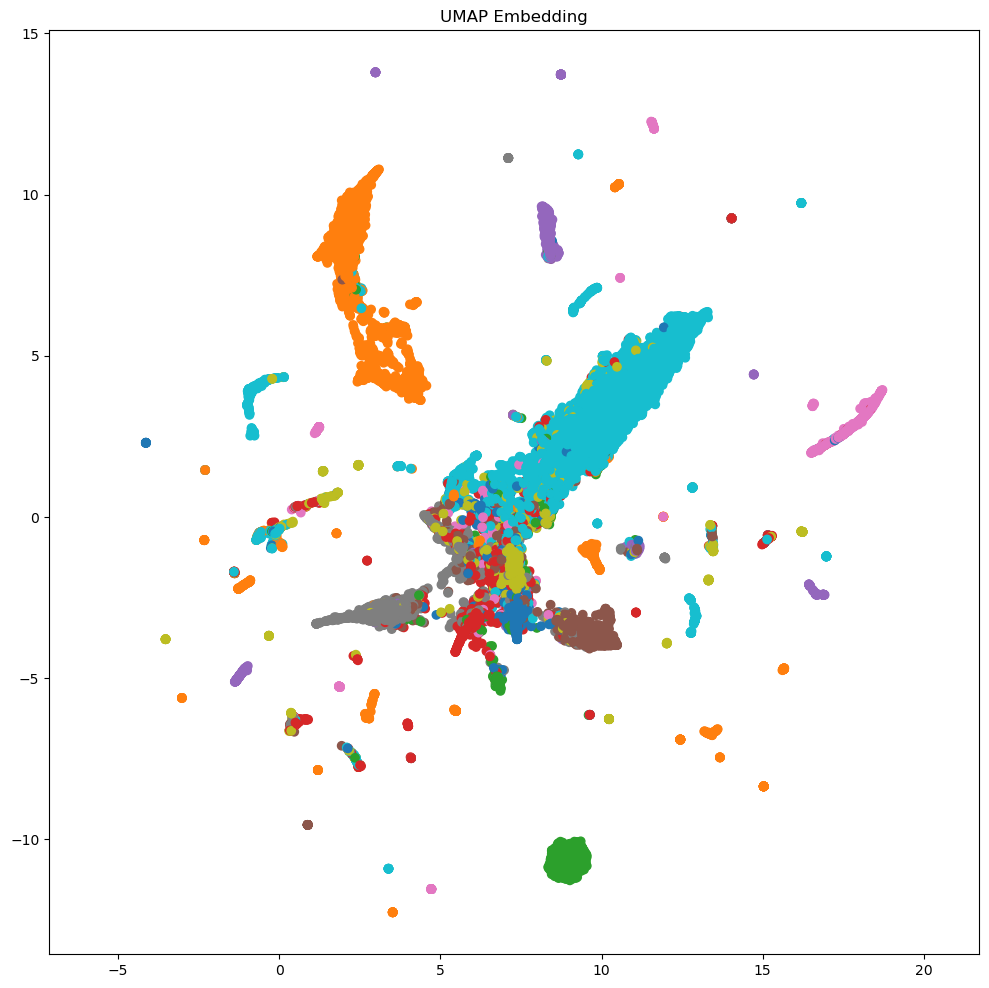

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

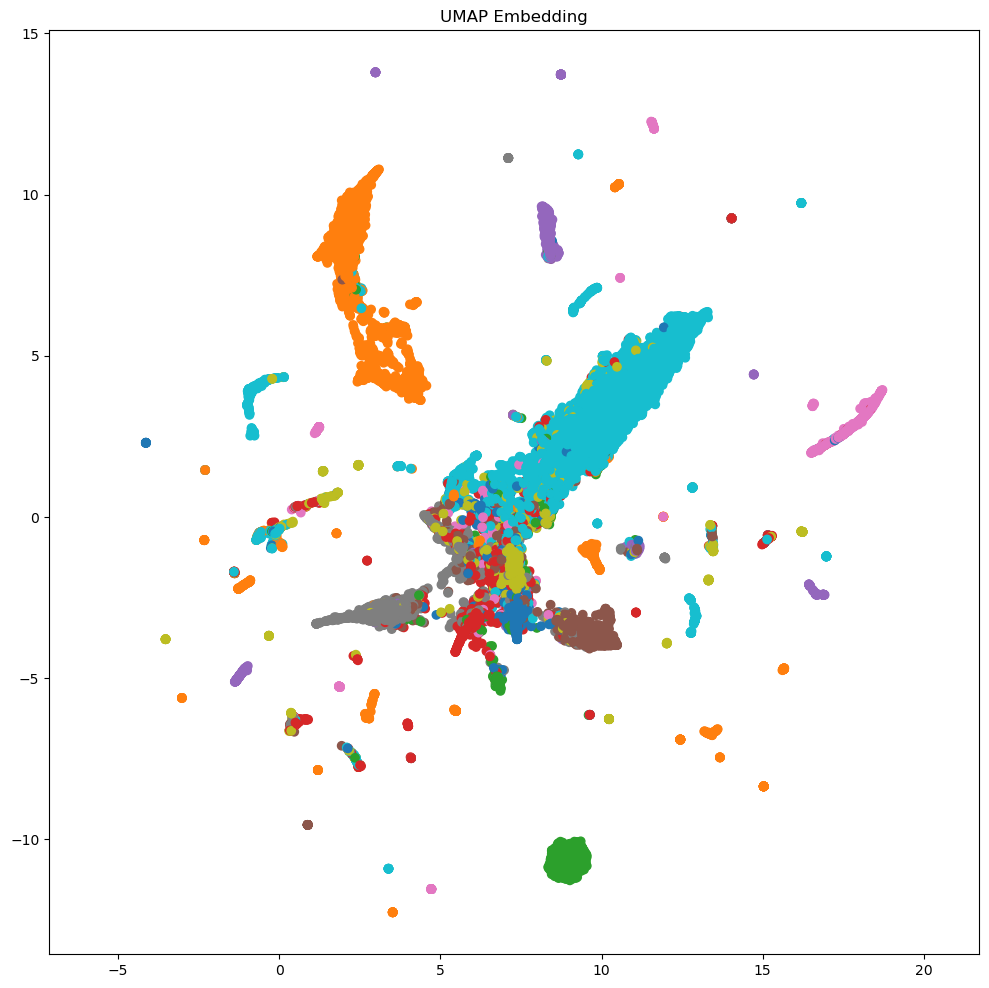

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1],
    c=[sns.color_palette()[x] for x in labels],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

In [43]:

#patch_list = []
models = []
embeddings = []
patch_emb=[] #ADDED
for d in dates[:5]:
    patch = tg_graphs[d]
    model = VGAE(encoder=Encoder(64, patch.num_node_features))
    model, _ = train(patch, model, VGAE_loss, num_epochs=5, lr=0.01)
    patch_emb.append(Patch(patch.nodes, model.encode(patch).detach().numpy())) #ADDED
    #coordinates = model.encode(patch).detach().numpy()
    models.append(model)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.639428615570068


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.698056221008301


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.647350311279297


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.70219612121582


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0: loss=6.650152683258057


In [63]:
patch_emb[1].index

{188: 0,
 1373: 1,
 1333: 2,
 4017: 3,
 400: 4,
 22410: 5,
 1162: 6,
 1607: 7,
 466: 8,
 1316: 9,
 259: 10,
 5144: 11,
 10: 12,
 14466: 13,
 12361: 14,
 22863: 15,
 30702: 16,
 2426: 17,
 6751: 18,
 1581: 19,
 69495: 20,
 36: 21,
 17393: 22,
 599: 23,
 6650: 24,
 1793: 25,
 3421: 26,
 81: 27,
 8036: 28,
 342: 29,
 36945: 30,
 25763: 31,
 245: 32,
 80351: 33,
 578: 34,
 734: 35,
 123: 36,
 16548: 37,
 11911: 38,
 17787: 39,
 699: 40,
 49524: 41,
 5705: 42,
 28878: 43,
 4647: 44,
 6715: 45,
 1245: 46,
 270: 47,
 430: 48,
 5774: 49,
 311: 50,
 853: 51,
 254: 52,
 74: 53,
 14640: 54,
 1153: 55,
 32: 56,
 12571: 57,
 309: 58,
 57957: 59,
 736: 60,
 15217: 61,
 56: 62,
 34039: 63,
 172: 64,
 685: 65,
 748: 66,
 3343: 67,
 661: 68,
 44529: 69,
 166: 70,
 2629: 71,
 1782: 72,
 1668: 73,
 1864: 74,
 26426: 75,
 1290: 76,
 345: 77,
 667: 78,
 1210: 79,
 629: 80,
 836: 81,
 58: 82,
 12553: 83,
 38: 84,
 11560: 85,
 94: 86,
 1545: 87,
 133: 88,
 57880: 89,
 1715: 90,
 241: 91,
 2157: 92,
 29: 93,


In [ ]:
# ADDED 
## HOW TO GET THE TOTAL EMBEDDING WITH NEW VERSION OF THE ALGORITHM

import manopt_optimization as mopt
intersection_nodes=mopt.double_intersections_nodes(patch_emb)

dim=64
res, emb =mopt.optimization(patch_emb, intersection_nodes, dim) #res contain the result of the optimization, i.e., scales, rotations and traslations,
                                                                # emb is the embedding of every nodes using the scales, rotations and translations 
                                                                #found with  the optimization

In [ ]:
#ADDED 
#TO GET THE EMBEDDING USING STANDARD L2G
pr=l2g.AlignmentProblem(patch_emb)
old_emb=pr.get_aligned_embedding()

In [ ]:
def reduce_data(data, date, most_common):
    countries = dl.get_nodes(ts=date)['country'].to_list()
    indices = [i for i in range(len(countries)) if countries[i] in most_common]
    points = data[indices, :]
    labels = [most_common.index(countries[i]) for i in indices]
    return points, labels

In [ ]:
def create_plot(umap_embedding, labels, p):
    fig, ax = plt.subplots(1, 1, figsize=(12,12))
    ax.scatter(
        umap_embedding[p][:, 0],
        umap_embedding[p][:, 1],
        c=[sns.color_palette()[x] for x in labels[p]],
        lw=1
    )
    return fig

In [ ]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')

In [ ]:
embeddings = []
for i,d in enumerate(dates):
    patch = tg_graphs[d]
    embeddings.append(models[i].encode(patch).detach().numpy())

In [ ]:
def create_umap(points, reducer):
    return reducer.fit(points)

In [ ]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean')
reducer.fit_transform(emb)

In [ ]:
points = []
labels = []
umaps = []
for i,d in enumerate(dates):
    p, l = reduce_data(embeddings[i], d, most_common)
    points.append(p)
    labels.append(l)
    umaps.append(create_umap(p, reducer))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(
    umaps[1][:, 0],
    umaps[1][:, 1],
    c=[sns.color_palette()[x] for x in labels[1]],
    lw=1
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(8,20))
for i in range(4):
    ax[i].scatter(
        umaps[i][:, 0],
        umaps[i][:, 1],
        c=[sns.color_palette()[x] for x in labels[i]],
        lw=1
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP Embedding', fontsize=12)
plt.show()